In [2]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
#Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 
df_train = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')

#take a sub sample to do EDA on and make sure it is not skewed by label (same ratio as full data set)
grouped = df_train.groupby('label')
df_sample = grouped.apply(lambda x: x.sample(frac=0.1, random_state=42))  # 1% sample
df_sample.reset_index(drop=True, inplace=True)

/var/folders/fx/dljhb1xs01zd1r8n975gbtcc0000gn/T/ipykernel_53142/3884212818.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = grouped.apply(lambda x: x.sample(frac=0.1, random_state=42))  # 1% sample


In [4]:
#training data size
print(df_train.info())
print(df_sample.info())
#there are 220025 training images and labels for the training data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22003 entries, 0 to 22002
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      22003 non-null  object
 1   label   22003 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 343.9+ KB
None


In [5]:
#load a sample of the images into the loaded_images array
loaded_images = []
def load_images(loaded_images, df_sample):
    for _, row in df_sample.iterrows():
        base_name = row['id'] 
        tif_name = base_name + '.tif'
        img_path = os.path.join('histopathologic-cancer-detection/train/', tif_name)
            
        # 2) Try to open the image
        try:
            with Image.open(img_path) as img:
                img_rgb = img.convert('RGB')   
                img_array = np.array(img_rgb)
                label = row['label']
                
                # Store (image array, label) for EDA
                loaded_images.append((img_array, label, base_name))
        except Exception as e:
            print(f"Warning: could not open {img_path}: {e}")
    print(f"Loaded {len(loaded_images)} images")
load_images(loaded_images,df_sample)

Loaded 22003 images


In [6]:
#using sets, I want to check and see if all files in the training dataframe match with images with the training folder.
#Sets allow for only unique names to appear once, and doing a difference on two sets compares elements in the set stringwise. 
all_tif_files = set(os.listdir('histopathologic-cancer-detection/train'))

df_filenames = set(row['id'] + '.tif' for _, row in df_train.iterrows()) 

#difference of sets
missing_in_folder = df_filenames - all_tif_files
missing_in_df = all_tif_files - df_filenames

print(f"Files in DF but not folder: {len(missing_in_folder)}")
print(f"Files in folder but not DF: {len(missing_in_df)}")



Files in DF but not folder: 0
Files in folder but not DF: 0


Good News! There are no differences between the folders file names and the dataframes file names. 

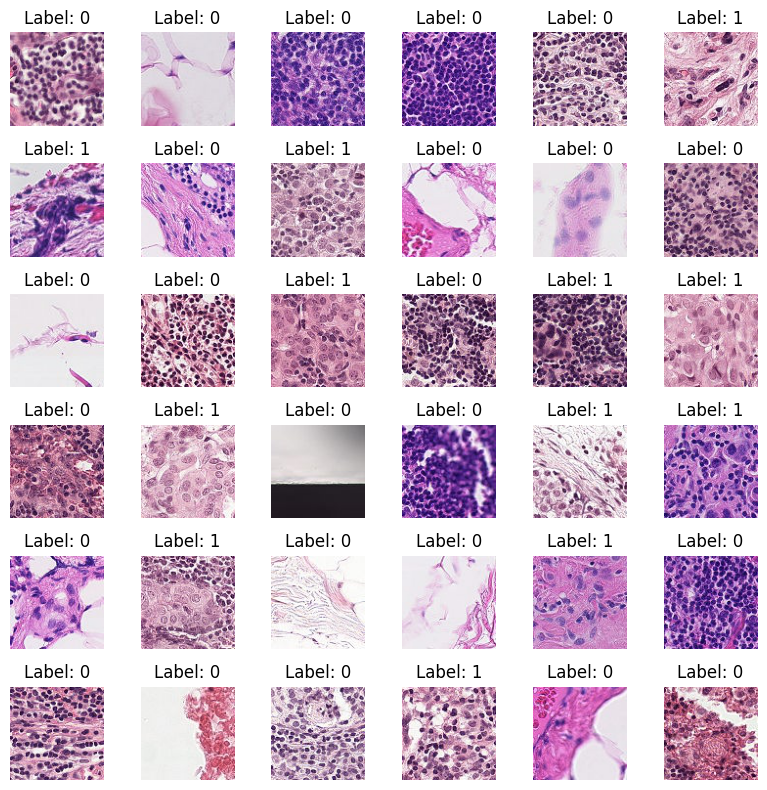

In [7]:
#display random sampling of images from the sample pulled from above
def show_random_images(loaded_images, n):
    samples = random.sample(loaded_images, n)
    cols = 6
    rows = n // cols
    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    for ax, (img_array, label, _) in zip(axes.flatten(), samples):
        ax.imshow(img_array)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_random_images(loaded_images, n=36)


The figure above gives a sample of different images and their labels. It shows that their are a wide variety of colors and features in each image. Many of them have circular looking cells in them, but at a glance are impossible to distiguish if they are cancerous or not to the untrained eye. 

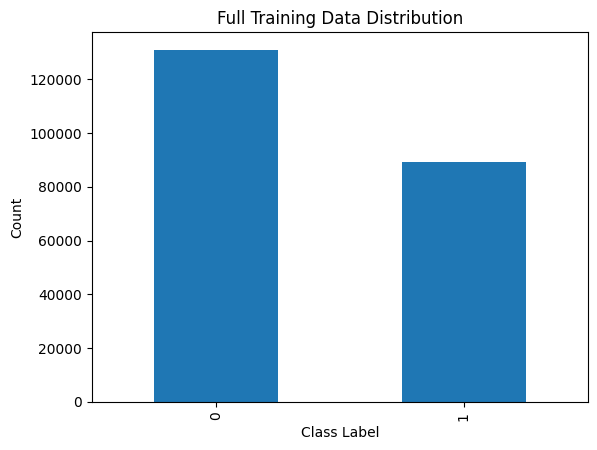

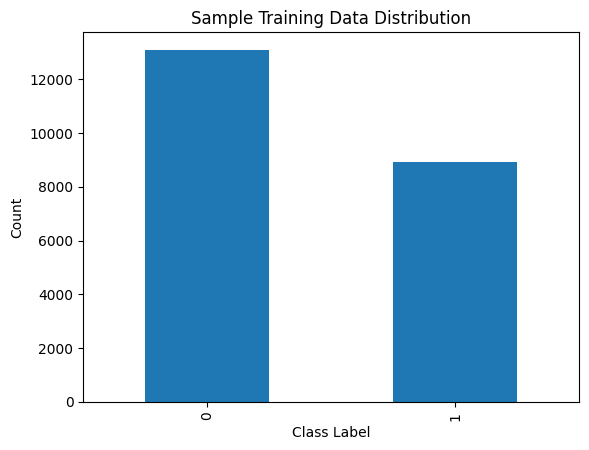

In [8]:
#EDA Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

#This is distribution of cancer vs no cancer in training images
def plot_label_distribution(df_label, title):
    label_counts = df_label['label'].value_counts()
    label_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.show()
plot_label_distribution(df_train, "Full Training Data Distribution")
plot_label_distribution(df_sample, "Sample Training Data Distribution")

#discuss reducing training size 

This shows that the full training data consists of more negatives than positives. It looks to be about 1.5x more likely to get a negative result. Additionally, the sample mirrors this ratio of negatives to positives.

In [9]:
#new list shapes, with dimensions of each image in loaded images which is based on df_samples
shapes = [img_array.shape for (img_array, _, _) in loaded_images]

#change shapes list to pandas series for use of value.counts() function
shape_counts = pd.Series(shapes).value_counts()

print("Shape counts in sample:")
print(shape_counts)

Shape counts in sample:
(96, 96, 3)    22003
Name: count, dtype: int64


Good News, they are all the same shape (for sampled images). 

In [10]:
#check different color distributions (R,G,B) for sampled images
r_mean, g_mean, b_mean = [], [], []

#loop over each image and average R,G,B values of the images and add to R,G,B arrays
for (img_array, _, _) in loaded_images:
    r_mean.append(np.mean(img_array[:, :, 0]))
    g_mean.append(np.mean(img_array[:, :, 1]))
    b_mean.append(np.mean(img_array[:, :, 2]))

#print averages of R,G,B results
print("Average R across sample:", np.mean(r_mean))
print("Average G across sample:", np.mean(g_mean))
print("Average B across sample:", np.mean(b_mean))

Average R across sample: 178.78880333197935
Average G across sample: 138.90189526317747
Average B across sample: 177.36826737168417


This shows that the images are a bit heavier on Blue and Red compared to Green. 

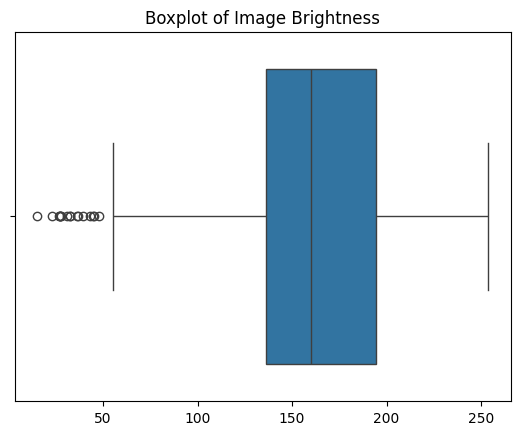

In [11]:
brightness_list_for_df = []
brightness = []
for (img_array, _, id) in loaded_images:
    brightness_value = np.mean(img_array)
    brightness.append(brightness_value)
    brightness_list_for_df.append({'id': id, 'brightness': brightness_value})

df_brightness = pd.DataFrame(brightness_list_for_df)
sns.boxplot(x=brightness)
plt.title("Boxplot of Image Brightness")
plt.show()

(0,0,0) is all black, whereas (255,255,255) is white. It appears the images skew towards bright and there are a few outliers that is significantly darker than the rest.  I am going to filter these values out from the sample training data so my model is not skewed by the few outliers. 

In [12]:
#merge df_brightness with df_sample on id so df_sample now has a brightness column
df_sample = df_sample.merge(df_brightness, on='id', how='left')

In [13]:
#now calculate threshold to filter by, I am picking 3 standard deviations based roughly on the box plot
threshold = df_sample['brightness'].mean() - 3 * df_sample['brightness'].std()
print(f"Threshold: {threshold}")

Threshold: 50.538899688600466


In [14]:
#now filter df_sample by that threshold
df_sample_filtered = df_sample[df_sample['brightness'] >= threshold].copy()

print(f"Filtered out images : {(len(df_sample) - len(df_sample_filtered))}")

Filtered out images : 17


In [15]:
#want to update the loaded images list now with the filtered df_sample.
loaded_images = []
load_images(loaded_images, df_sample_filtered)
print(len(loaded_images))

Loaded 21986 images
21986


This removed 17 images that were much darker than the rest of the data set. Now that the data set has been inspected and cleaned (thankfully it was very clean to begin with and I only had to do one filtering step), I can move on to training my convolutional neural network. 

In [18]:
#split into image and label data
X = np.array([img_array for (img_array, _, _) in loaded_images])  # shape (20000, 96, 96, 3)
y = np.array([label for (_, label, _) in loaded_images]) 

#normalize X data to be between 0 and 1
X = X.astype('float32') / 255.0

#split sample set into training and validation.  I will do a 75/25 split. 
X_train, X_validate, y_train, y_validate = train_test_split(X,y,)

In [19]:
#create the model
model = Sequential([
    Conv2D(30, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    # max pool to reduce size of output dimensions (could try stride change instead)
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(60, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # use Flatten so that the feature map can be acted on by neurons in dense layer
    Flatten(),

    #use relu activation for dense layer
    Dense(120, activation='relu'),
    # Trying dropouts to avoid overfitting, and faster compute time
    Dropout(0.5),

    # Output layer with sigmoid activation
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#using a low number of epochs to start and a batch size to update the model quicker
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=10, batch_size=32)

/Users/nickstanisic/workspace/jupyter/cancerdetection/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.6859 - loss: 0.6196 - val_accuracy: 0.7981 - val_loss: 0.4565
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7798 - loss: 0.4843 - val_accuracy: 0.7388 - val_loss: 0.5076
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7855 - loss: 0.4788 - val_accuracy: 0.7924 - val_loss: 0.4621
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.7998 - loss: 0.4461 - val_accuracy: 0.7853 - val_loss: 0.4616
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.8078 - loss: 0.4301 - val_accuracy: 0.7977 - val_loss: 0.4493
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.8153 - loss: 0.4048 - val_accuracy: 0.8092 - val_loss: 0.4390
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.8381 - loss: 0.3735 - val_accuracy: 0.7988 - val_loss: 0.4583
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.8562 - loss: 0.3360 - 

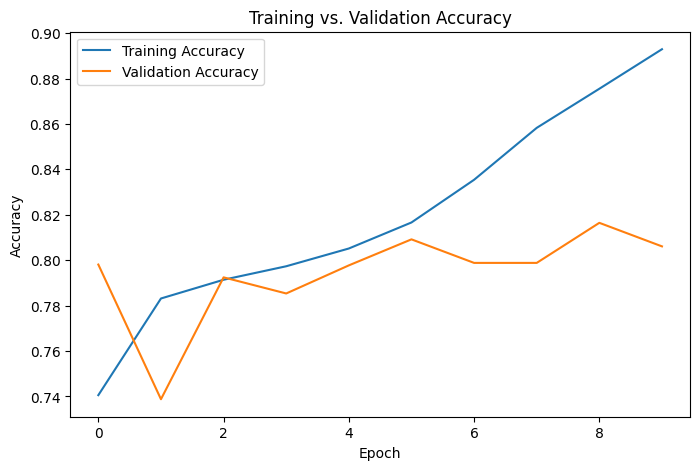

In [20]:
#compare accuracy of training data and validation data
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

Interestingly, my first model after about 5 epochs the validation accuracy levels out just above 80%. The training accuracy keeps increasing all the way to 90%. This indicates that it is overfitting after about 5 epochs. 

Hyperparameter Tuning:
I want to see if I can get a higher accuracy score so I will be using keras tuner below to try and find a better combination of hyperparameters. These include different numbers of filters, different drop out rates, changing the batch sizes and working with different gradient optimizers that adjust the learning rate and momentum for weight changes based on gradient calculations. 

In [ ]:
#Run hyperparameter tuning, try different architectures for comparison, 
#apply techniques to improve training or performance, and discuss what helped.
#Includes results with tables and figures. There is an analysis of why or why not something worked well, 
#troubleshooting, and a hyperparameter optimization procedure summary.



In [2]:
#Discuss and interpret results as well as learnings and takeaways. 
#What did and did not help improve the performance of your models? What improvements could you try in the future?


In [3]:
#Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard
